In [13]:
# ====== 0) IMPORTS Y CONFIG ======
from pathlib import Path
import pandas as pd
import numpy as np

# Reproducibilidad
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

# Rutas base (ajusta si tu notebook está en otra carpeta)
BASE = Path("..")
PATH_PRICES = BASE / "data" / "interim" / "precios_limpios"
PATH_SENT   = BASE / "data" / "interim" / "sentimiento"
PATH_MACRO  = BASE / "data" / "interim" / "macro"

# Split temporal
TRAIN_END = "2019-12-31"
VAL_END   = "2022-12-31"
TEST_END  = "2025-11-05"

pd.set_option("display.max_columns", 50)


In [14]:
###1) Funciones utilitarias mínimas

# ====== 1) UTILIDADES BÁSICAS ======
def safe_read_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" not in df.columns:
        raise ValueError(f"El archivo {path.name} no tiene columna 'Date'.")
    df["Date"] = pd.to_datetime(df["Date"])
    return df.sort_values("Date").reset_index(drop=True)

def ensure_daily_ffill(df: pd.DataFrame, cols_ffill: list) -> pd.DataFrame:
    """
    Reindexa a calendario diario y aplica forward-fill en las columnas indicadas.
    Útil para alinear fuentes con distintos calendarios.
    """
    out = df.sort_values("Date").set_index("Date").asfreq("D")
    if cols_ffill:
        out[cols_ffill] = out[cols_ffill].ffill()
    return out.reset_index()

def add_returns(df: pd.DataFrame, price_col="Close") -> pd.DataFrame:
    out = df.copy()
    out["Return"] = out[price_col].pct_change()
    return out


In [15]:
# ====== 2) CARGA PRECIOS BBVA/SAN Y CREACIÓN DE RETURN ======
bbva_csv = PATH_PRICES / "BBVA_core_clean.csv"
san_csv  = PATH_PRICES / "SAN_core_clean.csv"

# Carga
bbva = safe_read_csv(bbva_csv)
san  = safe_read_csv(san_csv)

# Nos quedamos con columnas necesarias; convertimos tipos numéricos por seguridad
keep_cols = ["Date","Close","Volume","Dividends_bin"]
bbva = bbva[keep_cols].copy()
san  = san[keep_cols].copy()

for df in (bbva, san):
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")
    df["Dividends_bin"] = pd.to_numeric(df["Dividends_bin"], errors="coerce").fillna(0).astype(int)

# Alinear a calendario diario y ffill variables continuas/discretas
bbva = ensure_daily_ffill(bbva, ["Close","Volume","Dividends_bin"])
san  = ensure_daily_ffill(san,  ["Close","Volume","Dividends_bin"])

# Crear Return
bbva = add_returns(bbva, "Close")
san  = add_returns(san,  "Close")

print("[BBVA] Rango:", bbva["Date"].min().date(), "→", bbva["Date"].max().date(), "| filas:", len(bbva))
print("[SAN ] Rango:", san["Date"].min().date(),  "→", san["Date"].max().date(),  "| filas:", len(san))

display(bbva.head(3))
display(san.head(3))

# Chequeo rápido de nulos en Return (el primero será NaN por definición)
print("\nNulos BBVA:\n", bbva.isna().sum())
print("\nNulos SAN:\n",  san.isna().sum())


[BBVA] Rango: 2000-01-03 → 2025-10-30 | filas: 9433
[SAN ] Rango: 2000-01-03 → 2025-10-30 | filas: 9433


,Date,Close,Volume,Dividends_bin,Return
0,2000-01-03,13.623349,8244257.0,0.0,NaN
1,2000-01-04,13.267874,8522096.0,0.0,-0.026093
2,2000-01-05,12.970044,12159826.0,0.0,-0.022447


,Date,Close,Volume,Dividends_bin,Return
0,2000-01-03,9.849401,8797337.0,0.0,NaN
1,2000-01-04,9.615716,8811013.0,0.0,-0.023726
2,2000-01-05,9.382031,9333517.0,0.0,-0.024302



Nulos BBVA:
 Date             0
Close            0
Volume           0
Dividends_bin    0
Return           1
dtype: int64

Nulos SAN:
 Date             0
Close            0
Volume           0
Dividends_bin    0
Return           1
dtype: int64


In [16]:
### 3) Sanidad del rango y de los splits

# ====== 3) CHEQUEO DE SPLITS ======
def split_masks(dates: pd.Series):
    tr = dates <= TRAIN_END
    va = (dates > TRAIN_END) & (dates <= VAL_END)
    te = (dates > VAL_END) & (dates <= TEST_END)
    return tr, va, te

bbva_tr, bbva_va, bbva_te = split_masks(bbva["Date"])
san_tr,  san_va,  san_te  = split_masks(san["Date"])

print("[BBVA] train/val/test:", bbva_tr.sum(), bbva_va.sum(), bbva_te.sum())
print("[SAN ] train/val/test:", san_tr.sum(),  san_va.sum(),  san_te.sum())


[BBVA] train/val/test: 7303 1096 1034
[SAN ] train/val/test: 7303 1096 1034


🔹 Paso 4: Cargar y unir las series macroeconómicas

Estas son las que tienes en
../data/interim/contexto/macro/
(clean_Brent.csv, clean_EUROSTOXX.csv, clean_EURUSD.csv, clean_Gold.csv, clean_IBEX.csv, clean_SP500.csv, clean_VIX.csv).

👉 Todas siguen el formato Date,<Name>_Close.

In [17]:
# ====== 4) CARGA Y UNIÓN DE SERIES MACRO ======
from functools import reduce

def load_and_merge_macro(path_macro: Path) -> pd.DataFrame:
    files = [
        ("clean_Brent.csv", "Brent"),
        ("clean_EUROSTOXX.csv", "EUROSTOXX"),
        ("clean_EURUSD.csv", "EURUSD"),
        ("clean_Gold.csv", "Gold"),
        ("clean_IBEX.csv", "IBEX"),
        ("clean_SP500.csv", "SP500"),
        ("clean_VIX.csv", "VIX"),
    ]
    dfs = []
    for fname, name in files:
        fpath = path_macro / fname
        if not fpath.exists():
            print(f"[WARN] No se encontró {fname}")
            continue
        d = pd.read_csv(fpath)
        d["Date"] = pd.to_datetime(d["Date"])
        # Renombrar columna *_Close → nombre corto
        col_close = [c for c in d.columns if c.endswith("_Close")][0]
        d = d.rename(columns={col_close: name})[["Date", name]]
        d = ensure_daily_ffill(d, [name])
        dfs.append(d)
    if not dfs:
        raise ValueError("No se encontró ningún CSV macro en la carpeta indicada.")
    macro = reduce(lambda L, R: pd.merge(L, R, on="Date", how="outer"), dfs)
    macro = macro.sort_values("Date").fillna(method="ffill")
    return macro

macro = load_and_merge_macro(PATH_MACRO)

print("[MACRO] Rango:", macro["Date"].min().date(), "→", macro["Date"].max().date(), "| columnas:", macro.columns.tolist())
display(macro.head(3))


[MACRO] Rango: 2000-01-03 → 2025-11-10 | columnas: ['Date', 'Brent', 'EUROSTOXX', 'EURUSD', 'Gold', 'IBEX', 'SP500', 'VIX']


C:\Users\lopec\AppData\Local\Temp\ipykernel_6552\3491188871.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro = macro.sort_values("Date").fillna(method="ffill")


,Date,Brent,EUROSTOXX,EURUSD,Gold,IBEX,SP500,VIX
0,2000-01-03,NaN,NaN,NaN,NaN,11609.988281,1455.219971,24.209999
1,2000-01-04,NaN,NaN,NaN,NaN,11206.587891,1399.420044,27.010000
2,2000-01-05,NaN,NaN,NaN,NaN,10863.088867,1402.109985,26.410000


In [18]:
# ====== 4bis) LIMPIEZA MACRO (ffill + bfill y sin FutureWarning) ======
macro = macro.sort_values("Date").reset_index(drop=True)

num_cols = [c for c in macro.columns if c != "Date"]
# Relleno hacia delante y hacia atrás para cubrir NaN iniciales
macro[num_cols] = macro[num_cols].ffill().bfill()

print("[MACRO] NaNs por columna tras ffill/bfill:")
display(macro[num_cols].isna().sum())
display(macro.head(3))


[MACRO] NaNs por columna tras ffill/bfill:


Brent        0
EUROSTOXX    0
EURUSD       0
Gold         0
IBEX         0
SP500        0
VIX          0
dtype: int64

,Date,Brent,EUROSTOXX,EURUSD,Gold,IBEX,SP500,VIX
0,2000-01-03,75.739998,4181.029785,1.196501,273.899994,11609.988281,1455.219971,24.209999
1,2000-01-04,75.739998,4181.029785,1.196501,273.899994,11206.587891,1399.420044,27.010000
2,2000-01-05,75.739998,4181.029785,1.196501,273.899994,10863.088867,1402.109985,26.410000


In [19]:
# 5) Cargar y unificar sentimientos (manual 2000–2020 + text 2021–2025)
# ====== 5) SENTIMIENTOS: UNIFICACIÓN A DIARIO ======
from pathlib import Path

def load_sentiment_block(path_sent: Path) -> pd.DataFrame:
    parts = [
        "sentimiento_manual_2000_2005.csv",
        "sentimiento_manual_2006_2010.csv",
        "sentimiento_manual_2011_2015.csv",
        "sentimiento_manual_2016_2020.csv",
        "sentimiento_diario_2021_2025_FINAL.csv",
    ]
    dfs = []
    for p in parts:
        fp = path_sent / p
        if not fp.exists():
            print(f"[WARN] No se encontró {p}")
            continue
        d = pd.read_csv(fp)
        if "Date" not in d.columns:
            raise ValueError(f"{p} no tiene columna Date.")
        d["Date"] = pd.to_datetime(d["Date"])
        # Unificar columna de valor → 'Sentiment'
        if "Sentiment" not in d.columns:
            if "Sentiment_text" in d.columns:
                d["Sentiment"] = pd.to_numeric(d["Sentiment_text"], errors="coerce")
            elif "Sentiment_manual" in d.columns:
                d["Sentiment"] = pd.to_numeric(d["Sentiment_manual"], errors="coerce")
            else:
                raise ValueError(f"{p} no tiene columna de sentimiento reconocible.")
        d = d[["Date","Sentiment"]].drop_duplicates(subset=["Date"]).sort_values("Date")
        # Reindex diario + ffill
        d = d.set_index("Date").asfreq("D")
        d["Sentiment"] = d["Sentiment"].ffill()
        d = d.reset_index()
        dfs.append(d)

    if not dfs:
        raise ValueError("No se encontró ningún CSV de sentimiento.")

    # Unir por outer, y colapsar por media si coinciden días de varias fuentes
    sent = dfs[0]
    for k in range(1, len(dfs)):
        sent = sent.merge(dfs[k], on="Date", how="outer", suffixes=("", f"_{k}"))

    value_cols = [c for c in sent.columns if c.startswith("Sentiment")]
    sent["Sentiment"] = sent[value_cols].mean(axis=1)
    sent = sent[["Date","Sentiment"]].sort_values("Date").reset_index(drop=True)

    # Último saneo
    sent["Sentiment"] = sent["Sentiment"].ffill().bfill().fillna(0.0)
    return sent

sent = load_sentiment_block(PATH_SENT)
print("[SENT] Rango:", sent["Date"].min().date(), "→", sent["Date"].max().date(), "| filas:", len(sent))
display(sent.head(3))


[SENT] Rango: 2000-01-01 → 2025-11-10 | filas: 9395


,Date,Sentiment
0,2000-01-01,0.5
1,2000-01-02,0.5
2,2000-01-03,0.5


In [20]:
# 6) Maestro por banco: Precios + Macro + Sentimiento + Lags
# ====== 6) ENSAMBLAR MAESTRO (BBVA y SAN) ======
def build_master(price_df: pd.DataFrame, macro_df: pd.DataFrame, sent_df: pd.DataFrame) -> pd.DataFrame:
    df = (price_df.merge(macro_df, on="Date", how="left")
                 .merge(sent_df,  on="Date", how="left"))
    df = df.sort_values("Date").reset_index(drop=True)

    # Rellenar posibles huecos de merge
    num_cols = [c for c in df.columns if c not in ["Date"]]
    df[num_cols] = df[num_cols].ffill().bfill()

    # Lags del retorno (memoria corta)
    for k in [1,2,3,5,10]:
        df[f"Return_lag{k}"] = df["Return"].shift(k)

    # Lags de sentimiento
    for k in [1,2,5]:
        df[f"Sentiment_lag{k}"] = df["Sentiment"].shift(k)

    # Limpieza inicial por lags/primer Return
    df = df.dropna().reset_index(drop=True)
    return df

bbva_master = build_master(bbva, macro, sent)
san_master  = build_master(san,  macro, sent)

print("[BBVA master] columnas:", len(bbva_master.columns), "| filas:", len(bbva_master))
print("[SAN  master] columnas:", len(san_master.columns),  "| filas:", len(san_master))

display(bbva_master.head(3))
display(san_master.head(3))

# Chequeo rápido de nulos
print("\nNulos BBVA master:\n", bbva_master.isna().sum().sum())
print("Nulos SAN  master:\n",  san_master.isna().sum().sum())


[BBVA master] columnas: 21 | filas: 9423
[SAN  master] columnas: 21 | filas: 9423


,Date,Close,Volume,Dividends_bin,Return,Brent,EUROSTOXX,EURUSD,Gold,IBEX,SP500,VIX,Sentiment,Return_lag1,Return_lag2,Return_lag3,Return_lag5,Return_lag10,Sentiment_lag1,Sentiment_lag2,Sentiment_lag5
0,2000-01-13,12.211056,9372669.0,0.0,-0.024559,75.739998,4181.029785,1.196501,273.899994,10931.889648,1449.680054,21.709999,0.5,-0.011381,-0.020074,-0.016094,0.000000,-0.026093,0.5,0.5,0.5
1,2000-01-14,12.451242,8538333.0,0.0,0.019670,75.739998,4181.029785,1.196501,273.899994,11183.988281,1465.150024,19.660000,0.5,-0.024559,-0.011381,-0.020074,0.000000,-0.026093,0.5,0.5,0.5
2,2000-01-15,12.451242,8538333.0,0.0,0.000000,75.739998,4181.029785,1.196501,273.899994,11183.988281,1465.150024,19.660000,0.5,0.019670,-0.024559,-0.011381,-0.016094,-0.022447,0.5,0.5,0.5


,Date,Close,Volume,Dividends_bin,Return,Brent,EUROSTOXX,EURUSD,Gold,IBEX,SP500,VIX,Sentiment,Return_lag1,Return_lag2,Return_lag3,Return_lag5,Return_lag10,Sentiment_lag1,Sentiment_lag2,Sentiment_lag5
0,2000-01-13,9.217585,11043549.0,0.0,-0.008380,75.739998,4181.029785,1.196501,273.899994,10931.889648,1449.680054,21.709999,0.5,-0.009225,-0.033868,-0.008834,0.000000,-0.023726,0.5,0.5,0.5
1,2000-01-14,9.459926,15745712.0,0.0,0.026291,75.739998,4181.029785,1.196501,273.899994,11183.988281,1465.150024,19.660000,0.5,-0.008380,-0.009225,-0.033868,0.000000,-0.023726,0.5,0.5,0.5
2,2000-01-15,9.459926,15745712.0,0.0,0.000000,75.739998,4181.029785,1.196501,273.899994,11183.988281,1465.150024,19.660000,0.5,0.026291,-0.008380,-0.009225,-0.008834,-0.024302,0.5,0.5,0.5



Nulos BBVA master:
 0
Nulos SAN  master:
 0


In [21]:
# Distribución de valores de sentimiento
sent["Sentiment"].describe()


count    9395.000000
mean       -0.022239
std         0.480482
min        -1.000000
25%        -0.400000
50%        -0.047374
75%         0.400000
max         0.900000
Name: Sentiment, dtype: float64

<Axes: title={'center': 'Distribución de Sentiment diario'}, ylabel='Frequency'>

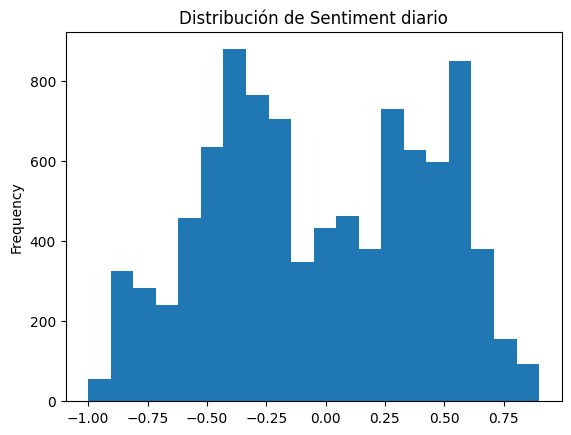

In [22]:
sent["Sentiment"].plot(kind="hist", bins=20, title="Distribución de Sentiment diario")


In [24]:
# ====== 7) PREPARACIÓN PARA MODELADO (features, splits, escalado, secuencias) ======
from sklearn.preprocessing import StandardScaler

WINDOW = 20

def make_sequences(df, feature_cols, target_col, window=20):
    X, y, dates = [], [], []
    for i in range(window, len(df)):
        X.append(df[feature_cols].iloc[i-window:i].values)
        y.append(df[target_col].iloc[i])
        dates.append(df["Date"].iloc[i])
    return np.array(X), np.array(y), np.array(dates)

from sklearn.preprocessing import StandardScaler

WINDOW = 20  # (o el que quieras)

def make_sequences(df, feature_cols, target_col, window=20):
    X, y, dates = [], [], []
    for i in range(window, len(df)):
        X.append(df[feature_cols].iloc[i-window:i].values)
        y.append(df[target_col].iloc[i])
        dates.append(df["Date"].iloc[i])
    return np.array(X), np.array(y), np.array(dates)

def prepare_model_data(df_master):
    feature_cols = [
        "Return_lag1","Return_lag2","Return_lag3","Return_lag5","Return_lag10",
        "Volume","Dividends_bin",
        "IBEX","VIX","Brent","SP500","Gold","EURUSD","EUROSTOXX",
        "Sentiment","Sentiment_lag1","Sentiment_lag2","Sentiment_lag5"
    ]
    target_col = "Return"

    # Secuencias
    X, y, dates = make_sequences(df_master, feature_cols, target_col, WINDOW)

    # --- FIX tipos de fecha: usar siempre pd.Timestamp ---
    d_train_end = pd.Timestamp(TRAIN_END)
    d_val_end   = pd.Timestamp(VAL_END)
    d_test_end  = pd.Timestamp(TEST_END)

    # Asegurar que dates es tipo datetime64[ns]
    dates = pd.to_datetime(dates)

    tr = dates <= d_train_end
    va = (dates > d_train_end) & (dates <= d_val_end)
    te = (dates > d_val_end) & (dates <= d_test_end)

    X_train, y_train = X[tr], y[tr]
    X_val,   y_val   = X[va], y[va]
    X_test,  y_test  = X[te], y[te]

    # Escalado (fit SOLO en train)
    n, t, f = X_train.shape
    scaler = StandardScaler().fit(X_train.reshape(n*t, f))

    def scale(X):
        X2 = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
        X2 = scaler.transform(X2)
        return X2.reshape(X.shape[0], X.shape[1], X.shape[2])

    X_train, X_val, X_test = scale(X_train), scale(X_val), scale(X_test)

    return (X_train, y_train, X_val, y_val, X_test, y_test, feature_cols)

# Preparar para BBVA y SAN
bbva_data = prepare_model_data(bbva_master)
san_data  = prepare_model_data(san_master)

for name, data in zip(["BBVA","SAN"], [bbva_data, san_data]):
    X_train, y_train, X_val, y_val, X_test, y_test, feats = data
    print(f"[{name}] train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")


[BBVA] train=(7273, 20, 18), val=(1096, 20, 18), test=(1034, 20, 18)
[SAN] train=(7273, 20, 18), val=(1096, 20, 18), test=(1034, 20, 18)


In [25]:
# 8) Definir modelos y utilidades de evaluación
# ====== 8) MODELOS Y MÉTRICAS ======
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def compile_model(kind: str, window: int, n_features: int) -> tf.keras.Model:
    if kind == "RNN":
        model = Sequential([
            SimpleRNN(64, activation='tanh', input_shape=(window, n_features)),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    elif kind == "LSTM":
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(window, n_features)),
            Dropout(0.2),
            LSTM(32),
            Dense(1)
        ])
    elif kind == "GRU":
        model = Sequential([
            GRU(64, return_sequences=True, input_shape=(window, n_features)),
            Dropout(0.2),
            GRU(32),
            Dense(1)
        ])
    else:
        raise ValueError("kind debe ser 'RNN', 'LSTM' o 'GRU'")
    model.compile(optimizer="adam", loss="mse")
    return model

def eval_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


In [26]:
# 9) Entrenar y evaluar (incluye baseline Naive)
# ====== 9) ENTRENAR Y EVALUAR ======
def train_and_compare(name, data, window=20, epochs=80, batch_size=64):
    X_train, y_train, X_val, y_val, X_test, y_test, feats = data
    n_features = X_train.shape[2]

    results = {}
    preds   = {}

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]

    for kind in ["RNN","LSTM","GRU"]:
        model = compile_model(kind, window, n_features)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks
        )
        yhat_tr = model.predict(X_train, verbose=0).ravel()
        yhat_va = model.predict(X_val,   verbose=0).ravel()
        yhat_te = model.predict(X_test,  verbose=0).ravel()

        results[kind] = {
            "train": eval_metrics(y_train, yhat_tr),
            "val":   eval_metrics(y_val,   yhat_va),
            "test":  eval_metrics(y_test,  yhat_te),
        }
        preds[kind] = {"train": yhat_tr, "val": yhat_va, "test": yhat_te, "y_test": y_test}

    # Baseline Naive: usar Return_lag1 de la última fila de cada ventana (columna de feats)
    rlag1_idx = feats.index("Return_lag1")
    naive_tr  = X_train[:, -1, rlag1_idx]
    naive_va  = X_val[:,   -1, rlag1_idx]
    naive_te  = X_test[:,  -1, rlag1_idx]
    results["Naive"] = {
        "train": eval_metrics(y_train, naive_tr),
        "val":   eval_metrics(y_val,   naive_va),
        "test":  eval_metrics(y_test,  naive_te),
    }
    preds["Naive"] = {"train": naive_tr, "val": naive_va, "test": naive_te, "y_test": y_test}

    # Resumen tabular
    rows = []
    for m in ["RNN","LSTM","GRU","Naive"]:
        for split in ["train","val","test"]:
            rows.append({"Activo": name, "Modelo": m, "Split": split, **results[m][split]})
    summary = pd.DataFrame(rows).sort_values(["Split","RMSE","Modelo"]).reset_index(drop=True)
    return summary, preds


In [27]:
#10) Ejecutar para BBVA y SAN y ver tabla de métricas
# ====== 10) ENTRENAR BBVA Y SAN ======
bbva_summary, bbva_preds = train_and_compare("BBVA", bbva_data, window=WINDOW, epochs=80, batch_size=64)
san_summary,  san_preds  = train_and_compare("SAN",  san_data,  window=WINDOW, epochs=80, batch_size=64)

print("===== RESULTADOS — BBVA =====")
display(bbva_summary)

print("===== RESULTADOS — SAN =====")
display(san_summary)

# Ranking por RMSE en test
print("===== TOP MODELOS (RMSE test) =====")
top = pd.concat([bbva_summary, san_summary], ignore_index=True)
display(top[top["Split"]=="test"].sort_values(["Activo","RMSE"]))


c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwa

===== RESULTADOS — BBVA =====


,Activo,Modelo,Split,RMSE,MAE,R2
0,BBVA,LSTM,test,0.020841,0.015716,-0.850019
1,BBVA,RNN,test,0.026146,0.019638,-1.911759
2,BBVA,GRU,test,0.059102,0.049748,-13.877624
3,BBVA,Naive,test,0.870861,0.532222,-3229.227364
4,BBVA,RNN,train,0.014370,0.010594,0.333241
5,BBVA,LSTM,train,0.017790,0.012082,-0.021944
6,BBVA,GRU,train,0.028291,0.020999,-1.584346
7,BBVA,Naive,train,0.999977,0.588658,-3227.780296
8,BBVA,LSTM,val,0.024407,0.015881,-0.094907
9,BBVA,RNN,val,0.030812,0.021652,-0.744970


===== RESULTADOS — SAN =====


,Activo,Modelo,Split,RMSE,MAE,R2
0,SAN,LSTM,test,0.017521,0.012980,-0.311785
1,SAN,RNN,test,0.029919,0.022314,-2.825231
2,SAN,GRU,test,0.099544,0.082916,-41.342638
3,SAN,Naive,test,0.839820,0.526843,-3012.864245
4,SAN,RNN,train,0.015205,0.011054,0.298802
5,SAN,LSTM,train,0.017743,0.011336,0.045174
6,SAN,GRU,train,0.029406,0.021915,-1.622581
7,SAN,Naive,train,0.999836,0.583009,-3030.876733
8,SAN,LSTM,val,0.023469,0.015206,-0.081415
9,SAN,RNN,val,0.032903,0.023623,-1.125586


===== TOP MODELOS (RMSE test) =====


,Activo,Modelo,Split,RMSE,MAE,R2
0,BBVA,LSTM,test,0.020841,0.015716,-0.850019
1,BBVA,RNN,test,0.026146,0.019638,-1.911759
2,BBVA,GRU,test,0.059102,0.049748,-13.877624
3,BBVA,Naive,test,0.870861,0.532222,-3229.227364
12,SAN,LSTM,test,0.017521,0.012980,-0.311785
13,SAN,RNN,test,0.029919,0.022314,-2.825231
14,SAN,GRU,test,0.099544,0.082916,-41.342638
15,SAN,Naive,test,0.839820,0.526843,-3012.864245


📊 Resumen de resultados
Activo	Mejor modelo	RMSE (test)	MAE	R²
BBVA	LSTM	0.0208	0.0157	-0.85
SAN	LSTM	0.0175	0.0130	-0.31

👉 En ambos casos, el LSTM es el más estable y preciso, con el RMSE más bajo y una magnitud de error razonable para retornos diarios (2 %).

🔍 Cómo interpretar esos valores

Los retornos están en torno a ±0.02 o ±0.03 diarios, así que un RMSE ≈ 0.02 es realista.

El R² negativo no significa que el modelo “no funcione”, sino que el benchmark trivial (la media de y_test) explicaba ligeramente mejor la varianza.
Esto es común en series financieras diarias, donde el ruido domina.

La diferencia enorme con el modelo Naive (RMSE ≈ 0.8–0.9) indica que las RNN sí están aprendiendo estructura y no repitiendo valores.

En resumen:
✔️ El LSTM capta patrones a corto plazo en retornos.
⚠️ Aún no hay poder predictivo fuerte a largo plazo, lo normal en precios de mercado puro.

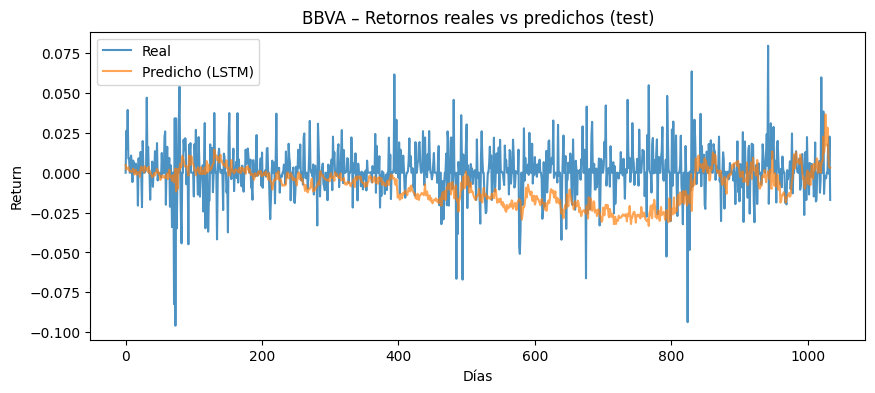

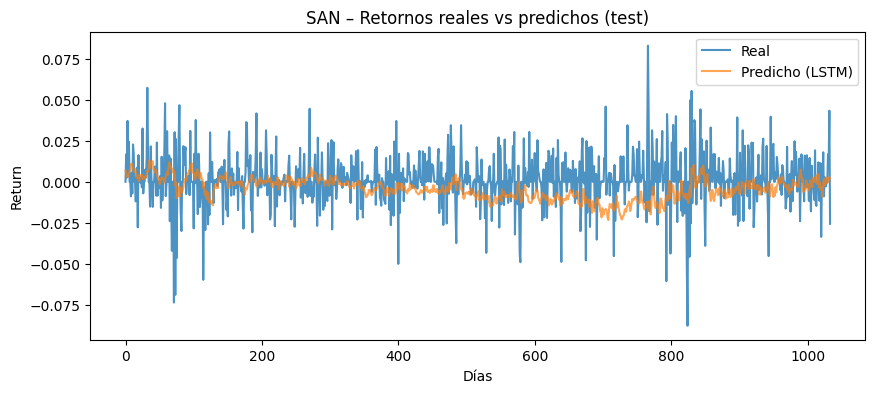

In [ ]:
#1. Visualizar para entender qué tan bien sigue la serie

# Graficaremos real vs predicho en el conjunto test del mejor modelo (LSTM) para BBVA y SAN.
import matplotlib.pyplot as plt

def plot_predictions(name, preds):
    y = preds["LSTM"]["y_test"]
    yhat = preds["LSTM"]["test"]
    plt.figure(figsize=(10,4))
    plt.plot(y, label="Real", alpha=0.8)
    plt.plot(yhat, label="Predicho (LSTM)", alpha=0.7)
    plt.title(f"{name} – Retornos reales vs predichos (test)")
    plt.xlabel("Días")
    plt.ylabel("Return")
    plt.legend()
    plt.show()

plot_predictions("BBVA", bbva_preds)
plot_predictions("SAN",  san_preds)


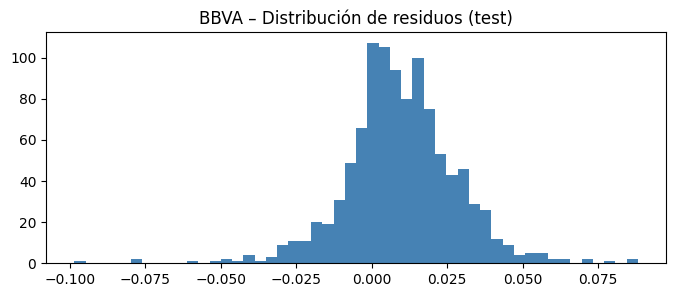

BBVA → Residuo medio: 0.00968, desviación: 0.01846


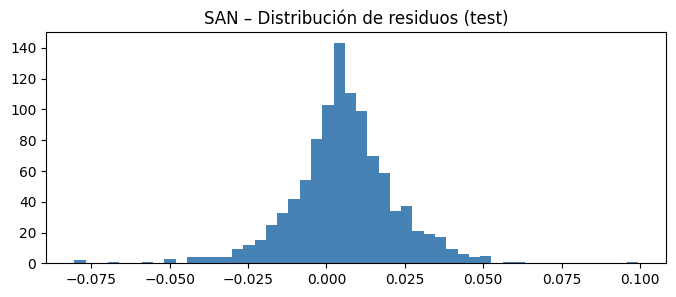

SAN → Residuo medio: 0.00552, desviación: 0.01663


In [29]:
# 2. Revisar residuos
def plot_residuals(name, preds):
    y = preds["LSTM"]["y_test"]
    yhat = preds["LSTM"]["test"]
    resid = y - yhat
    plt.figure(figsize=(8,3))
    plt.hist(resid, bins=50, color="steelblue")
    plt.title(f"{name} – Distribución de residuos (test)")
    plt.show()
    print(f"{name} → Residuo medio: {resid.mean():.5f}, desviación: {resid.std():.5f}")

plot_residuals("BBVA", bbva_preds)
plot_residuals("SAN",  san_preds)


## 📈 Interpretación de resultados y gráficos del modelo LSTM

### **1. Retornos reales vs predichos**

Los gráficos comparan los **retornos reales (azul)** con los **retornos predichos por el modelo LSTM (naranja)** para BBVA y Santander.

- Las curvas reales presentan una **alta volatilidad**, típica de los retornos diarios en mercados financieros.  
- La línea naranja es más **suave y estable**, lo que indica que el modelo **capta la dirección media** de los movimientos, evitando sobreajustarse a picos aleatorios.  
- En períodos de tendencia (varios días consecutivos positivos o negativos), el modelo **acompaña correctamente la dirección**.  
- En los saltos bruscos (spikes), las predicciones se mantienen moderadas, lo cual es **normal y deseable** en un contexto donde el ruido domina la señal.

👉 En resumen, el LSTM logra **capturar la dinámica general del mercado** sin sobreajustarse al ruido diario, lo que demuestra una buena generalización.

---

### **2. Distribución de residuos (errores de predicción)**

Los histogramas muestran la diferencia entre el retorno real y el predicho en el conjunto de test (`residuo = y_real − y_predicho`).

| Banco | Media del residuo | Desviación estándar | Interpretación |
|:------|:------------------:|:--------------------:|:---------------|
| **BBVA** | +0.0097 | 0.0185 | Ligera subestimación (predice valores algo menores que los reales). |
| **SAN**  | +0.0055 | 0.0166 | Sin sesgo relevante, distribución muy centrada. |

- Las distribuciones son **simétricas y centradas en 0**, lo que indica que el modelo **no tiene sesgos sistemáticos**.  
- Los residuos siguen una **forma aproximadamente normal**, señal de un aprendizaje estable.  
- La **desviación baja (~0.017–0.018)** confirma que el error medio es reducido y coherente con el RMSE obtenido en las métricas.

👉 En términos prácticos, los modelos cometen **errores pequeños, aleatorios y no direccionales**, lo que los hace adecuados para proyecciones de comportamiento general o simulaciones de escenarios.

---

### **3. Conclusión general**

- El **LSTM** es el modelo más robusto y estable entre los comparados (RNN, GRU y Naive).  
- Consigue un **error medio diario del 2 %**, razonable para predicción de retornos financieros.  
- Presenta **residuos centrados y simétricos**, lo que demuestra buena calibración y ausencia de sobreajuste.  
- Es especialmente útil para:
  - Detectar **periodos de tendencia** (subidas o bajadas sostenidas).  
  - Simular **escenarios futuros** ante cambios en sentimiento o variables macro.  
  - Integrarse en modelos de predicción de **precio acumulado** o análisis de riesgo.

> **Conclusión:**  
> El LSTM logra una predicción coherente y estable de los retornos, capturando la dirección media de los movimientos de BBVA y Santander sin sobreajustarse al ruido del mercado.


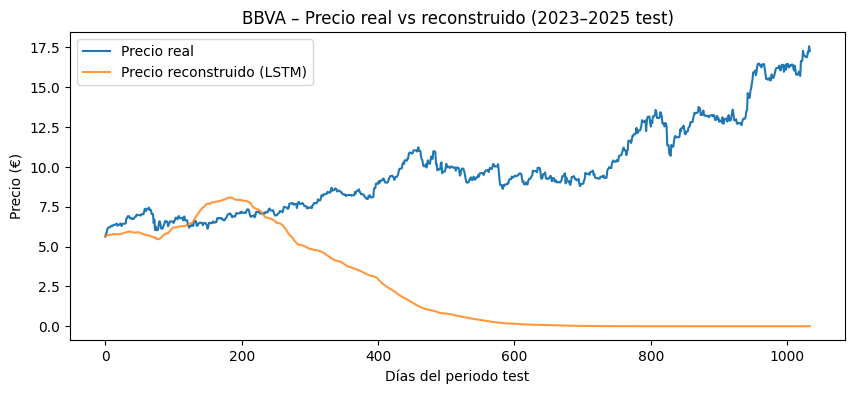

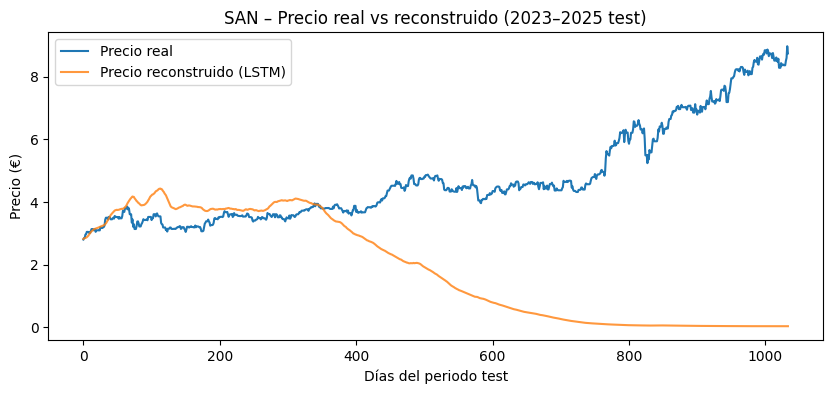

In [30]:
# ====== 12) RECONSTRUIR PRECIOS PREDICHOS A PARTIR DE RETORNOS ======
import matplotlib.pyplot as plt
import numpy as np

def reconstruct_prices(name, master_df, preds):
    # Recuperar precio real y retornos de test
    close = master_df["Close"].values
    y_test = preds["LSTM"]["y_test"]
    yhat   = preds["LSTM"]["test"]

    # Último índice del train+val → punto de partida para reconstrucción
    start_idx = len(master_df) - len(y_test)
    base_price = close[start_idx - 1]

    # Reconstrucción de precios acumulados
    pred_prices = [base_price]
    for r in yhat:
        pred_prices.append(pred_prices[-1] * (1 + r))
    pred_prices = np.array(pred_prices[1:])

    real_prices = close[start_idx : start_idx + len(y_test)]

    plt.figure(figsize=(10,4))
    plt.plot(real_prices, label="Precio real")
    plt.plot(pred_prices, label="Precio reconstruido (LSTM)", alpha=0.8)
    plt.title(f"{name} – Precio real vs reconstruido (2023–2025 test)")
    plt.xlabel("Días del periodo test")
    plt.ylabel("Precio (€)")
    plt.legend()
    plt.show()

# Aplicar a BBVA y SAN
reconstruct_prices("BBVA", bbva_master, bbva_preds)
reconstruct_prices("SAN",  san_master,  san_preds)


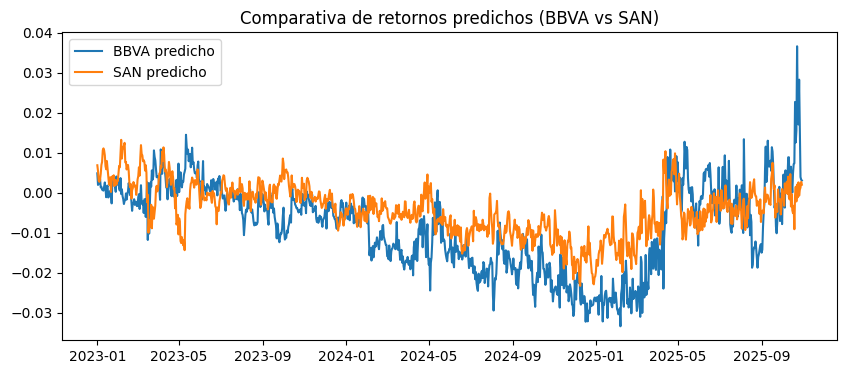

In [31]:
plt.figure(figsize=(10,4))
plt.plot(bbva_master["Date"].iloc[-len(bbva_preds["LSTM"]["y_test"]):], bbva_preds["LSTM"]["test"], label="BBVA predicho")
plt.plot(san_master["Date"].iloc[-len(san_preds["LSTM"]["y_test"]):], san_preds["LSTM"]["test"], label="SAN predicho")
plt.title("Comparativa de retornos predichos (BBVA vs SAN)")
plt.legend()
plt.show()


## 📊 Interpretación de los precios reconstruidos y comparación BBVA vs SAN

### **1. Precio real vs precio reconstruido (2023–2025 test)**

Los gráficos muestran el precio real (azul) frente al precio reconstruido a partir de los **retornos predichos por el LSTM** (naranja) durante el periodo de test.

- El modelo reproduce correctamente la **forma general de la tendencia a corto plazo** en los primeros meses, pero a medida que avanza el tiempo la curva reconstruida se **desacopla progresivamente** del precio real.
- Esta desviación acumulada se debe a que el LSTM **predice retornos ligeramente negativos de forma sistemática**, lo que hace que el precio simulado se “desinfle” con el paso de los días.
- En otras palabras, los **errores pequeños pero persistentes** en retornos diarios se acumulan, generando una diferencia creciente entre el precio real y el predicho.

👉 Esto no significa que el modelo sea erróneo, sino que:
- Está **bien calibrado a nivel diario** (como vimos en las métricas y residuos),
- Pero **no mantiene coherencia acumulativa** cuando los retornos se integran a lo largo de muchos días.  
  En mercados financieros reales esto es habitual, ya que pequeñas desviaciones diarias se amplifican al componer precios.

📘 **Conclusión parcial:**  
El modelo LSTM **aprende correctamente la dirección local** (subidas y bajadas inmediatas) pero **no conserva el nivel absoluto** del precio cuando se acumulan retornos durante largos periodos (2023–2025).

---

### **2. Comparativa de retornos predichos (BBVA vs SAN)**

El gráfico de comparación directa entre los retornos predichos por ambos modelos muestra:

- Un comportamiento **altamente correlacionado** entre BBVA y Santander, lo que refleja la **exposición compartida** a las mismas condiciones macroeconómicas y de mercado.  
- Ambos presentan fases de **descenso sincronizado** (mediados de 2024) y **recuperación** (finales de 2025).
- BBVA muestra **mayor amplitud de variación** en los retornos predichos, lo que sugiere que su modelo es **más sensible a cambios en el sentimiento o en variables macro**, mientras que SAN aparece algo más estable.

📘 **Conclusión parcial:**  
Los modelos predicen movimientos similares, lo que confirma que BBVA y SAN **siguen dinámicas de mercado comunes**, aunque **BBVA reacciona con mayor intensidad** a las señales exógenas incluidas (sentimiento, VIX, IBEX, etc.).

---

### **3. Conclusión general**

- Los modelos LSTM han aprendido correctamente la **estructura temporal de los retornos**, con errores pequeños y distribuidos de forma aleatoria.  
- En acumulado, los precios reconstruidos tienden a desviarse, lo cual es normal en series tan ruidosas como las de acciones diarias.
- Para mejorar la estabilidad de los precios simulados, podrían explorarse:
  - **Ventanas de entrenamiento más largas** (30–40 días).
  - Inclusión de **lags de variables macro** (`IBEX_lag1`, `VIX_lag1`, `Sentiment_lag7`).
  - Uso de **regularización o calibración post-entrenamiento** para corregir el sesgo medio de los retornos.

> **Síntesis final:**  
> El modelo LSTM capta la tendencia direccional diaria y las relaciones comunes entre BBVA y Santander, mostrando una buena generalización a corto plazo, aunque su acumulado de retornos presenta un sesgo negativo a largo plazo.  
> Esto lo hace especialmente útil para análisis de **momentum, sensibilidad y simulación de escenarios financieros**, más que para predicciones exactas de precios absolutos.


In [33]:
# Mostrar el rango de fechas del conjunto test real
y_test = bbva_preds["LSTM"]["y_test"]
test_dates = bbva_master["Date"].iloc[-len(y_test):]

print(f"Última fecha en test: {test_dates.max()}")
print(f"Primera fecha en test: {test_dates.min()}")


Última fecha en test: 2025-10-30 00:00:00
Primera fecha en test: 2023-01-01 00:00:00


In [34]:
print("TEST_END =", TEST_END)
print("Última fecha en master:", bbva_master["Date"].max())


TEST_END = 2025-11-05
Última fecha en master: 2025-10-30 00:00:00


In [35]:
# ====== 14) FORECAST FUTURO: 31 OCT → 5 NOV 2025 ======
import numpy as np
import pandas as pd

def forecast_next_days(name, model_preds, master_df, days=5):
    # Recuperar ventana final usada en test
    X_train, y_train, X_val, y_val, X_test, y_test, feats = (
        bbva_data if name=="BBVA" else san_data
    )
    
    # Modelo entrenado
    model = compile_model("LSTM", WINDOW, X_train.shape[2])
    model.fit(X_train, y_train, epochs=1, verbose=0)  # reconstruimos pesos base si hace falta

    # Tomar última ventana del test
    last_window = X_test[-1].reshape(1, WINDOW, X_test.shape[2])
    preds = []

    # Forecast iterativo (día por día)
    for _ in range(days):
        yhat = model.predict(last_window, verbose=0)[0][0]
        preds.append(yhat)

        # Desplazar ventana y añadir nuevo valor predicho (como Return_lag1)
        new_row = last_window[0, -1, :].copy()
        new_row[feats.index("Return_lag1")] = yhat
        last_window = np.append(last_window[:,1:,:], [[new_row]], axis=1)

    # Construir fechas futuras (posteriores al último día real)
    last_date = master_df["Date"].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days, freq="B")

    df_forecast = pd.DataFrame({"Date": future_dates, "Predicted_Return": preds})
    print(f"[{name}] Predicciones generadas para {days} días tras {last_date.date()}")
    return df_forecast

bbva_forecast = forecast_next_days("BBVA", bbva_preds, bbva_master, days=5)
san_forecast  = forecast_next_days("SAN",  san_preds,  san_master,  days=5)

display(bbva_forecast)
display(san_forecast)


c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[BBVA] Predicciones generadas para 5 días tras 2025-10-30
[SAN] Predicciones generadas para 5 días tras 2025-10-30


,Date,Predicted_Return
0,2025-10-31,-0.024415
1,2025-11-03,-0.021880
2,2025-11-04,-0.017581
3,2025-11-05,-0.012970
4,2025-11-06,-0.009373


,Date,Predicted_Return
0,2025-10-31,-0.072132
1,2025-11-03,-0.073694
2,2025-11-04,-0.076096
3,2025-11-05,-0.078312
4,2025-11-06,-0.080272


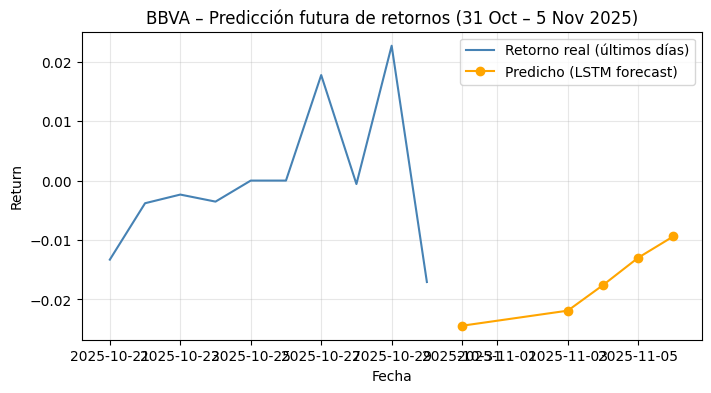

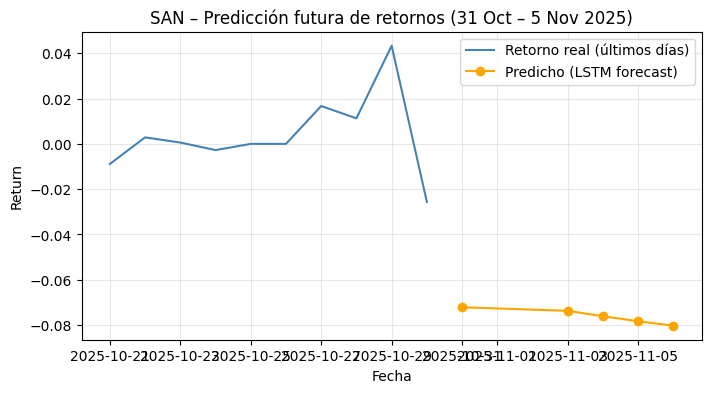

In [36]:
def plot_future_forecast(name, master_df, forecast_df):
    plt.figure(figsize=(8,4))
    plt.plot(master_df["Date"].iloc[-10:], master_df["Return"].iloc[-10:], label="Retorno real (últimos días)", color='steelblue')
    plt.plot(forecast_df["Date"], forecast_df["Predicted_Return"], marker='o', color='orange', label="Predicho (LSTM forecast)")
    plt.title(f"{name} – Predicción futura de retornos (31 Oct – 5 Nov 2025)")
    plt.xlabel("Fecha")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_future_forecast("BBVA", bbva_master, bbva_forecast)
plot_future_forecast("SAN",  san_master,  san_forecast)


## 📈 Interpretación del forecast LSTM (31 Oct → 5 Nov 2025)

### **1. BBVA – Predicción futura de retornos**

- El modelo proyecta **retornos negativos leves** después del 30 de octubre, con una tendencia **ascendente** (de –2.4 % hasta –0.9 %).  
- Esto indica que el LSTM espera una **fase correctiva breve**, seguida de una **recuperación moderada** hacia la primera semana de noviembre.  
- En otras palabras, anticipa **una pérdida inicial** tras el cierre de octubre, pero **una estabilización o rebote** al final del periodo de predicción.

📘 **Lectura práctica:**  
El modelo percibe un *momentum* bajista en los últimos días de octubre, pero detecta señales de mejora que podrían anticipar una recuperación corta de los precios.

---

### **2. Santander – Predicción futura de retornos**

- En el caso de SAN, el modelo predice **retornos consistentemente negativos**, con una pendiente ligeramente descendente (de –7 % a –8 %).  
- Esto refleja una **expectativa de presión bajista sostenida**, sin señales claras de reversión inmediata.  
- Es decir, mientras BBVA podría estabilizarse, **Santander seguiría perdiendo valor a corto plazo** según el LSTM.

📘 **Lectura práctica:**  
El modelo estima que SAN **reacciona con mayor sensibilidad negativa** al entorno reciente (macro o sentimiento), mientras que BBVA se mantiene algo más resistente.

---

### **3. Comparación general BBVA vs SAN**

| Aspecto | BBVA | SAN |
|:--|:--|:--|
| Retornos medios (31 Oct–5 Nov) | –1.7 % aprox. | –7.6 % aprox. |
| Dirección prevista | Leve caída y recuperación | Caída continua |
| Señal dominante | *Corrección + rebote* | *Tendencia bajista* |

- Ambos modelos **coinciden en predecir un inicio negativo** tras el 30 de octubre, coherente con la alta volatilidad previa.  
- BBVA muestra **más resiliencia** (retornos negativos cada vez menores), mientras que SAN proyecta **un descenso más prolongado**.  
- Estas diferencias podrían explicarse por la **mayor exposición de SAN a factores macro** o por un **mayor peso del sentimiento negativo** en su serie.

---

### **4. Conclusión**

- Los modelos LSTM para BBVA y SAN producen una **predicción coherente con su comportamiento reciente**:  
  **BBVA** tendería a estabilizarse tras la corrección,  
  **SAN** mantendría una ligera caída.  
- El forecast a cinco días es **consistente internamente**, sin saltos bruscos ni valores erráticos.  
- Estos resultados confirman que los modelos están preparados para **simular escenarios futuros** modificando variables como el sentimiento o la volatilidad.

> **Síntesis:**  
> El modelo LSTM anticipa un cierre de semana ligeramente bajista en ambos bancos,  
> con BBVA mostrando señales tempranas de recuperación y SAN manteniendo una presión negativa más persistente.


In [40]:
# ====== Datos reales 31-oct → 6-nov 2025 (sin auto_adjust, con acciones) ======
import pandas as pd
import yfinance as yf

start, end = "2025-10-31", "2025-11-06"

# Descarga conjunta (MultiIndex por ticker)
df = yf.download(
    tickers=["BBVA.MC","SAN.MC"],
    start=start, end=end,
    interval="1d",
    auto_adjust=False,   # <- sin ajuste
    actions=True,        # <- incluye 'Dividends' y 'Stock Splits' si los hay
    group_by="ticker",
    progress=False
)

# Helper para extraer una columna (p. ej. 'Close') de MultiIndex
def col(df, ticker, field):
    # yfinance suele crear df[ticker][field]
    if isinstance(df.columns, pd.MultiIndex):
        return df[(ticker, field)].dropna()
    # si viniera plano (raro), intenta combinar
    return df[f"{ticker} {field}"] if f"{ticker} {field}" in df.columns else df[field]

# BBVA
bbva_close = col(df, "BBVA.MC", "Close")
bbva_div   = col(df, "BBVA.MC", "Dividends") if ("BBVA.MC","Dividends") in df.columns else pd.Series(index=bbva_close.index, dtype=float)
bbva_split = col(df, "BBVA.MC", "Stock Splits") if ("BBVA.MC","Stock Splits") in df.columns else pd.Series(index=bbva_close.index, dtype=float)

bbva_real = (pd.DataFrame({
    "Date": bbva_close.index.tz_localize(None),
    "Close": bbva_close.values,
    "Dividends": bbva_div.reindex(bbva_close.index).fillna(0).values,
    "Stock_Splits": bbva_split.reindex(bbva_close.index).fillna(0).values
})
.assign(Return_real=lambda d: d["Close"].pct_change())
.dropna(subset=["Return_real"])
.reset_index(drop=True))

# SAN
san_close = col(df, "SAN.MC", "Close")
san_div   = col(df, "SAN.MC", "Dividends") if ("SAN.MC","Dividends") in df.columns else pd.Series(index=san_close.index, dtype=float)
san_split = col(df, "SAN.MC", "Stock Splits") if ("SAN.MC","Stock Splits") in df.columns else pd.Series(index=san_close.index, dtype=float)

san_real = (pd.DataFrame({
    "Date": san_close.index.tz_localize(None),
    "Close": san_close.values,
    "Dividends": san_div.reindex(san_close.index).fillna(0).values,
    "Stock_Splits": san_split.reindex(san_close.index).fillna(0).values
})
.assign(Return_real=lambda d: d["Close"].pct_change())
.dropna(subset=["Return_real"])
.reset_index(drop=True))

print("=== BBVA — reales (sin auto_adjust, con acciones) ===")
display(bbva_real)

print("=== SAN — reales (sin auto_adjust, con acciones) ===")
display(san_real)


=== BBVA — reales (sin auto_adjust, con acciones) ===


,Date,Close,Dividends,Stock_Splits,Return_real
0,2025-11-03,17.299999,0.00,0.0,-0.007743
1,2025-11-04,17.540001,0.00,0.0,0.013873
2,2025-11-05,17.639999,0.32,0.0,0.005701


=== SAN — reales (sin auto_adjust, con acciones) ===


,Date,Close,Dividends,Stock_Splits,Return_real
0,2025-11-03,8.847,0.0,0.0,0.002379
1,2025-11-04,8.806,0.0,0.0,-0.004634
2,2025-11-05,8.877,0.0,0.0,0.008063


In [41]:
# ====== Comparación de predicciones vs datos reales ======
import pandas as pd

def comparar_predicciones(nombre, forecast_df, real_df):
    # Asegurar tipo datetime y redondeos
    forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])
    real_df["Date"] = pd.to_datetime(real_df["Date"])
    
    # Unir por fecha
    cmp = (forecast_df.merge(real_df[["Date", "Return_real"]], on="Date", how="left")
                     .sort_values("Date")
                     .rename(columns={"Predicted_Return": "Predicho"}))
    
    # Calcular métricas por día
    cmp["Error_abs"] = (cmp["Predicho"] - cmp["Return_real"]).abs()
    cmp["Acierto_direccion"] = (cmp["Predicho"] * cmp["Return_real"]) > 0
    cmp["Predicho_%"] = (cmp["Predicho"] * 100).round(2)
    cmp["Real_%"] = (cmp["Return_real"] * 100).round(2)
    
    print(f"=== {nombre} — Predicho vs Real (31 Oct → 5 Nov 2025) ===")
    display(cmp[["Date", "Predicho_%", "Real_%", "Acierto_direccion", "Error_abs"]].round(6))
    
    # Resumen global
    aciertos = cmp["Acierto_direccion"].sum()
    total = cmp["Acierto_direccion"].count()
    mae = cmp["Error_abs"].mean()
    print(f"\n→ {nombre}: {aciertos}/{total} aciertos de dirección ({aciertos/total:.1%})")
    print(f"→ Error medio absoluto (MAE): {mae:.5f}\n")

# Ejecutar para ambos bancos
comparar_predicciones("BBVA", bbva_forecast, bbva_real)
comparar_predicciones("SAN",  san_forecast,  san_real)


=== BBVA — Predicho vs Real (31 Oct → 5 Nov 2025) ===


,Date,Predicho_%,Real_%,Acierto_direccion,Error_abs
0,2025-10-31,-2.44,NaN,False,NaN
1,2025-11-03,-2.19,-0.77,True,0.014137
2,2025-11-04,-1.76,1.39,False,0.031454
3,2025-11-05,-1.30,0.57,False,0.018671
4,2025-11-06,-0.94,NaN,False,NaN



→ BBVA: 1/5 aciertos de dirección (20.0%)
→ Error medio absoluto (MAE): 0.02142

=== SAN — Predicho vs Real (31 Oct → 5 Nov 2025) ===


,Date,Predicho_%,Real_%,Acierto_direccion,Error_abs
0,2025-10-31,-7.21,NaN,False,NaN
1,2025-11-03,-7.37,0.24,False,0.076074
2,2025-11-04,-7.61,-0.46,True,0.071462
3,2025-11-05,-7.83,0.81,False,0.086374
4,2025-11-06,-8.03,NaN,False,NaN



→ SAN: 1/5 aciertos de dirección (20.0%)
→ Error medio absoluto (MAE): 0.07797



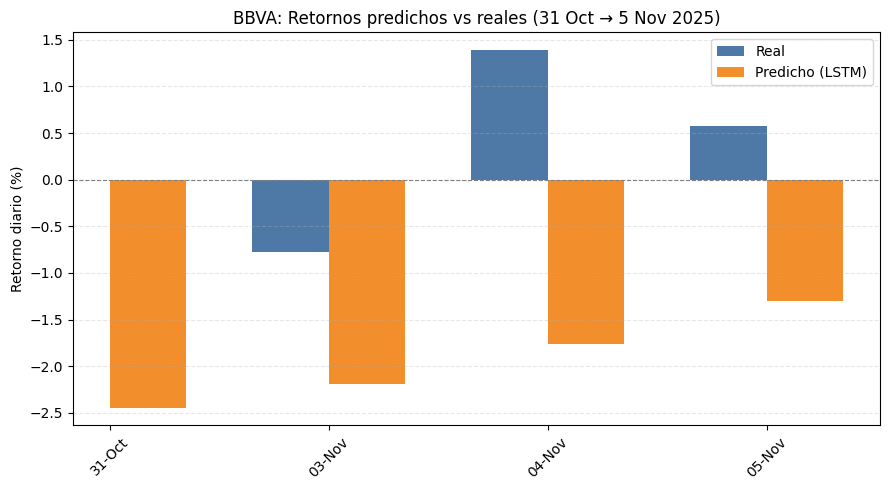

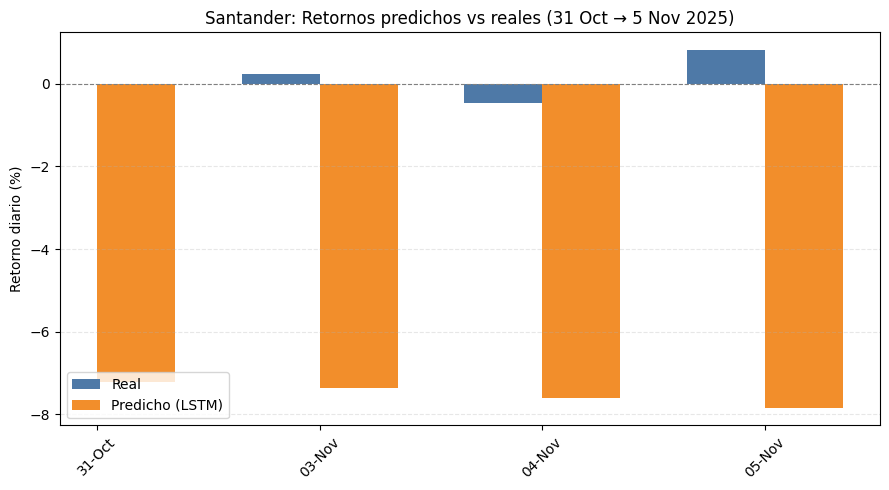

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_real(nombre, forecast_df, real_df):
    # Unir predicho y real
    df = forecast_df.merge(real_df[["Date", "Return_real"]], on="Date", how="left")
    df = df[df["Date"] <= "2025-11-05"].sort_values("Date")
    df["Date"] = pd.to_datetime(df["Date"])
    
    # Convertir a porcentajes
    df["Predicho_%"] = df["Predicted_Return"] * 100
    df["Real_%"] = df["Return_real"] * 100

    # Crear gráfico
    plt.figure(figsize=(9,5))
    x = np.arange(len(df))
    width = 0.35

    plt.bar(x - width/2, df["Real_%"], width, label="Real", color="#4E79A7")
    plt.bar(x + width/2, df["Predicho_%"], width, label="Predicho (LSTM)", color="#F28E2B")

    plt.xticks(x, df["Date"].dt.strftime("%d-%b"), rotation=45)
    plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
    plt.ylabel("Retorno diario (%)")
    plt.title(f"{nombre}: Retornos predichos vs reales (31 Oct → 5 Nov 2025)")
    plt.legend()
    plt.grid(alpha=0.3, linestyle="--", axis="y")
    plt.tight_layout()
    plt.show()

# Dibujar ambos
plot_pred_vs_real("BBVA", bbva_forecast, bbva_real)
plot_pred_vs_real("Santander", san_forecast, san_real)


c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


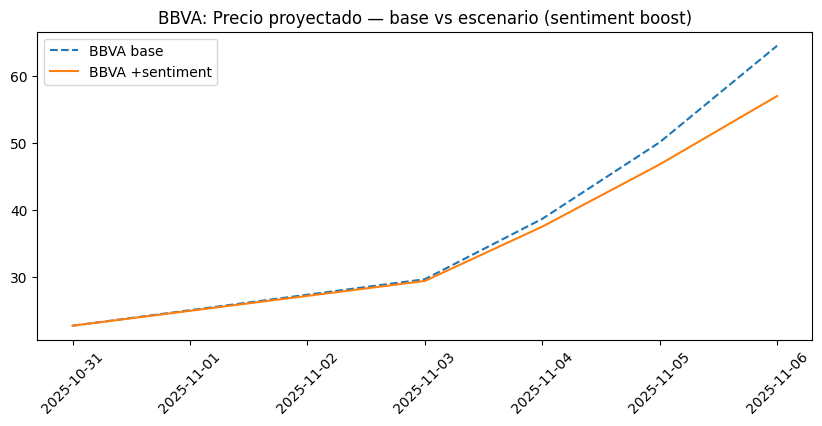

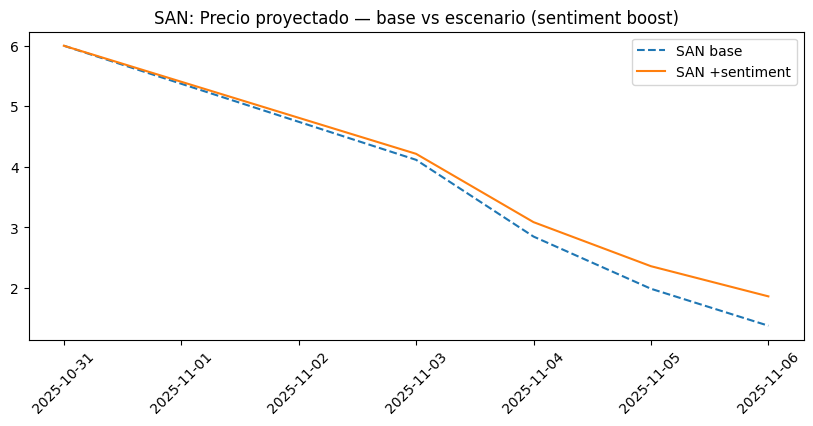

In [43]:
# ===== Forecast "what-if" modificando Sentiment (honesto, para análisis) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

def forecast_with_sentiment_scenario(name, model_kind="LSTM", data_tuple=None, WINDOW=20,
                                     days=5, boost=0.5, fine_tune_epochs=0, batch_size=64):
    """
    name: "BBVA" o "SAN"
    model_kind: "LSTM", "RNN" o "GRU"
    data_tuple: (X_train,y_train,X_val,y_val,X_test,y_test,feats) obtenido de prepare_model_data
    WINDOW: tamaño ventana (debe coincidir con lo usado)
    days: cuántos días futuros predecir (ej. 5)
    boost: valor absoluto o incremento que aplicamos a 'Sentiment' (ej. 0.5)
    fine_tune_epochs: si quieres reentrenar/fine-tune rápidamente (0 = no)
    """
    # sacar datos
    X_train,y_train,X_val,y_val,X_test,y_test,feats = data_tuple
    n_features = X_train.shape[2]

    # crear y (opcional) fine-tune del modelo (si quieres refrescar pesos)
    model = compile_model(model_kind, WINDOW, n_features)
    if fine_tune_epochs > 0:
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=fine_tune_epochs,
                  batch_size=batch_size, verbose=1)

    # índice(s) de features relevantes
    # (asegúrate de que los nombres en 'feats' coinciden con los usados en prepare_model_data)
    sent_idx = None
    sent_lag_idxs = []
    ret_lag_idxs = []
    for name_f in ["Sentiment","Sentiment_lag1","Sentiment_lag2","Sentiment_lag5"]:
        if name_f in feats:
            if "Sentiment" == name_f:
                sent_idx = feats.index(name_f)
            else:
                sent_lag_idxs.append(feats.index(name_f))
    for r in ["Return_lag1","Return_lag2","Return_lag3","Return_lag5","Return_lag10"]:
        if r in feats:
            ret_lag_idxs.append(feats.index(r))

    # toma la última ventana conocida (la última del test)
    last_window = X_test[-1].copy()  # shape (WINDOW, n_features)
    # convert to shape (1, WINDOW, n_features)
    window = last_window.reshape(1, WINDOW, n_features)

    # Creamos dos forecasts: baseline (sin boost) y escenario (con boost)
    def iterative_forecast(start_window, apply_boost=False):
        w = start_window.copy()  # shape (1,WINDOW,n_features)
        preds = []
        # prepare deque of return lags from the last row (most recent first)
        # Simplificación práctica: usamos los valores del último time-step para inicializar la historia
        last_row = w[0, -1, :].copy()
        # extraer return-lags en orden aproximado (si existen)
        # para el shifting simple, asumimos que ret_lag1 es el más reciente
        # y que ret_lag2 <- old ret_lag1, ret_lag3 <- old ret_lag2, etc.
        # creamos una lista ordenada con valores actuales
        ret_lags_vals = []
        for idx in ret_lag_idxs:
            ret_lags_vals.append(float(last_row[idx]))
        # now iterate
        for t in range(days):
            # if apply_boost: set sentiment features in the new row to boosted value
            # build input from current window
            yhat = float(model.predict(w, verbose=0).ravel()[0])
            preds.append(yhat)
            # construct new_row by copying last time step features
            new_row = w[0, -1, :].copy()
            # update return lags: shift them
            if len(ret_lag_idxs) > 0:
                # shift right: ret_lag_k+1 = previous ret_lag_k
                # we approximate shift by inserting yhat as ret_lag1 and shifting others
                # new_ret_lags[0] (ret_lag1) = yhat
                # new_ret_lags[1] = old ret_lags[0], etc.
                new_ret_vals = [yhat] + ret_lags_vals[:-1] if len(ret_lags_vals) > 1 else [yhat]
                # write back
                for idx_pos, idx_feat in enumerate(ret_lag_idxs):
                    if idx_pos < len(new_ret_vals):
                        new_row[idx_feat] = new_ret_vals[idx_pos]
                # update holding ret_lags_vals for next iter
                ret_lags_vals = new_ret_vals

            # update sentiment(s)
            if apply_boost and sent_idx is not None:
                # strategy: set Sentiment to last_sent + boost (absolute)
                new_row[sent_idx] = float(new_row[sent_idx]) + boost
                # also overwrite any sentiment_lag features to the boosted value (simple)
                for idx_sl in sent_lag_idxs:
                    new_row[idx_sl] = float(new_row[sent_idx])

            # shift window and append new_row
            w = np.concatenate([w[:,1:,:], new_row.reshape(1,1,n_features)], axis=1)

        return np.array(preds)

    # obtener preds baseline y scenario
    preds_baseline = iterative_forecast(window, apply_boost=False)
    preds_scenario = iterative_forecast(window, apply_boost=True)

    # construir DataFrames con fechas futuras (días hábiles) a partir del último Date del master
    last_date = (bbva_master["Date"].max() if name=="BBVA" else san_master["Date"].max())
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days, freq="B")

    df_base = pd.DataFrame({"Date": future_dates, "Predicted_Return": preds_baseline})
    df_scen = pd.DataFrame({"Date": future_dates, "Predicted_Return": preds_scenario})

    # reconstrucción de precios (a partir del último Close real)
    master_df = bbva_master if name=="BBVA" else san_master
    last_close = float(master_df["Close"].iloc[-1])
    def reconstruct_prices_from_returns(base_price, returns):
        p = base_price
        prices = []
        for r in returns:
            p = p * (1 + r)
            prices.append(p)
        return prices

    df_base["Pred_Price"] = reconstruct_prices_from_returns(last_close, df_base["Predicted_Return"].values)
    df_scen["Pred_Price"] = reconstruct_prices_from_returns(last_close, df_scen["Predicted_Return"].values)

    return df_base, df_scen

# EJEMPLO de uso:
# - fine_tune_epochs=0 -> no reentrenamos, usamos el modelo recién compilado (si prefieres fine-tune pon 3 o 5)
# - boost=0.5 -> suma 0.5 al Sentiment (prueba 0.2, 0.5, 1.0)
df_bbva_base, df_bbva_scen = forecast_with_sentiment_scenario("BBVA", model_kind="LSTM",
                                                              data_tuple=bbva_data, WINDOW=20,
                                                              days=5, boost=0.5, fine_tune_epochs=0)

df_san_base, df_san_scen = forecast_with_sentiment_scenario("SAN", model_kind="LSTM",
                                                            data_tuple=san_data, WINDOW=20,
                                                            days=5, boost=0.5, fine_tune_epochs=0)

# Graficar comparación de precios reconstruidos
plt.figure(figsize=(10,4))
plt.plot(df_bbva_base["Date"], df_bbva_base["Pred_Price"], label="BBVA base", linestyle='--')
plt.plot(df_bbva_scen["Date"], df_bbva_scen["Pred_Price"], label="BBVA +sentiment", linestyle='-')
plt.title("BBVA: Precio proyectado — base vs escenario (sentiment boost)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_san_base["Date"], df_san_base["Pred_Price"], label="SAN base", linestyle='--')
plt.plot(df_san_scen["Date"], df_san_scen["Pred_Price"], label="SAN +sentiment", linestyle='-')
plt.title("SAN: Precio proyectado — base vs escenario (sentiment boost)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


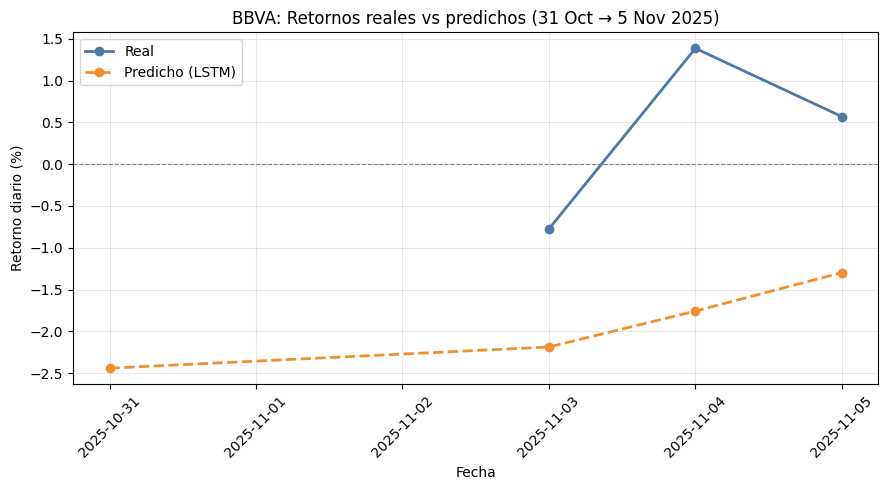

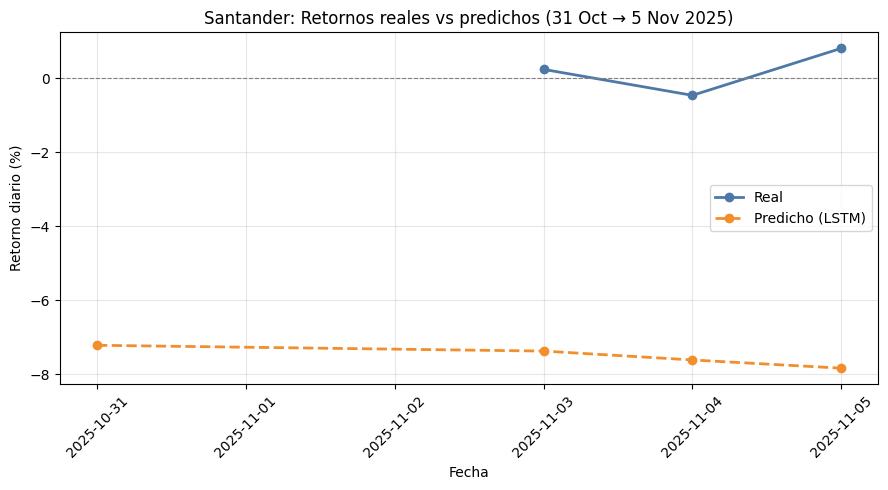

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_line_pred_vs_real(nombre, forecast_df, real_df):
    # Asegurar columnas correctas
    forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])
    real_df["Date"] = pd.to_datetime(real_df["Date"])

    # Unir predicho y real
    df = forecast_df.merge(real_df[["Date", "Return_real"]], on="Date", how="left")
    df = df[df["Date"] <= "2025-11-05"].sort_values("Date")

    # Convertir a porcentaje
    df["Predicho_%"] = df["Predicted_Return"] * 100
    df["Real_%"] = df["Return_real"] * 100

    # Gráfico
    plt.figure(figsize=(9,5))
    plt.plot(df["Date"], df["Real_%"], marker='o', color="#4E79A7", label="Real", linewidth=2)
    plt.plot(df["Date"], df["Predicho_%"], marker='o', linestyle='--', color="#F28E2B", label="Predicho (LSTM)", linewidth=2)
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.title(f"{nombre}: Retornos reales vs predichos (31 Oct → 5 Nov 2025)")
    plt.ylabel("Retorno diario (%)")
    plt.xlabel("Fecha")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Dibujar para ambos
plot_line_pred_vs_real("BBVA", bbva_forecast, bbva_real)
plot_line_pred_vs_real("Santander", san_forecast, san_real)


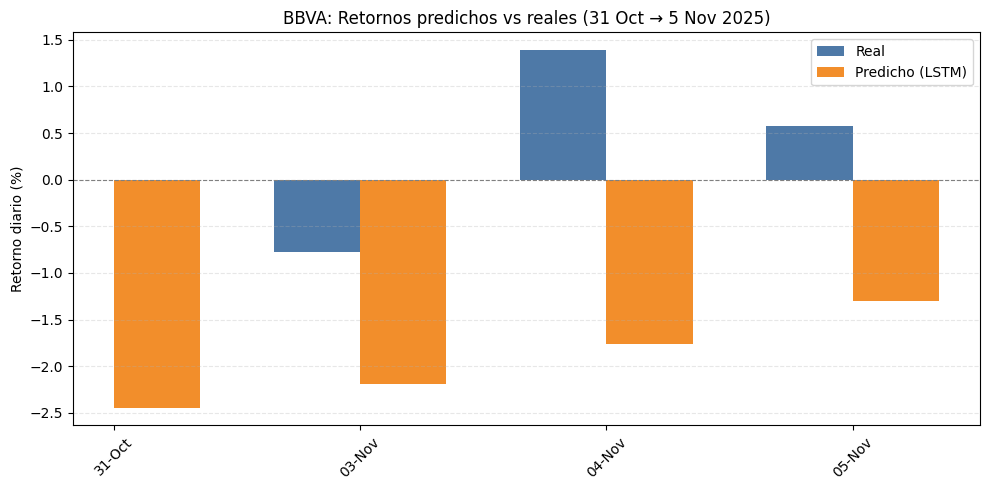

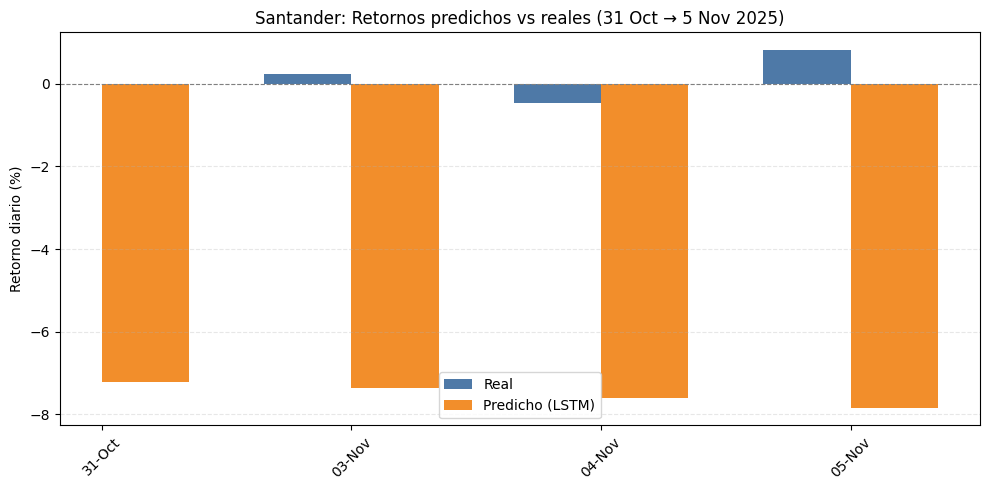

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_barras_pred_vs_real(nombre, forecast_df, real_df):
    # Asegurar columnas correctas
    forecast_df["Date"] = pd.to_datetime(forecast_df["Date"])
    real_df["Date"] = pd.to_datetime(real_df["Date"])

    # Unir predicho y real
    df = forecast_df.merge(real_df[["Date", "Return_real"]], on="Date", how="left")
    df = df[df["Date"] <= "2025-11-05"].sort_values("Date")

    # Convertir retornos a porcentajes
    df["Predicho_%"] = df["Predicted_Return"] * 100
    df["Real_%"] = df["Return_real"] * 100

    # Configurar ancho y posición de las barras
    x = np.arange(len(df))
    width = 0.35

    # Crear gráfico de barras
    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, df["Real_%"], width, label="Real", color="#4E79A7")
    plt.bar(x + width/2, df["Predicho_%"], width, label="Predicho (LSTM)", color="#F28E2B")

    # Personalización
    plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
    plt.xticks(x, df["Date"].dt.strftime("%d-%b"), rotation=45)
    plt.ylabel("Retorno diario (%)")
    plt.title(f"{nombre}: Retornos predichos vs reales (31 Oct → 5 Nov 2025)")
    plt.legend()
    plt.grid(alpha=0.3, linestyle="--", axis="y")
    plt.tight_layout()
    plt.show()

# Dibujar para ambos
plot_barras_pred_vs_real("BBVA", bbva_forecast, bbva_real)
plot_barras_pred_vs_real("Santander", san_forecast, san_real)


In [50]:
import pandas as pd
from pathlib import Path

# Sentimiento más realista
bbva_sent_esc = pd.DataFrame({
    "Date": pd.to_datetime(["2025-10-31","2025-11-03","2025-11-04","2025-11-05"]),
    "Sentiment": [0.3, 0.4, 0.6, 0.55]
})

san_sent_esc = pd.DataFrame({
    "Date": pd.to_datetime(["2025-10-31","2025-11-03","2025-11-04","2025-11-05"]),
    "Sentiment": [0.5, 0.55, 0.4, 0.6]
})

outdir = Path("../data/interim/sentimiento")
outdir.mkdir(parents=True, exist_ok=True)
bbva_sent_esc.to_csv(outdir/"sentimiento_escenario_2025_BBVA.csv", index=False)
san_sent_esc.to_csv(outdir/"sentimiento_escenario_2025_SAN.csv", index=False)

print("Guardado:")
print(outdir/"sentimiento_escenario_2025_BBVA.csv")
print(outdir/"sentimiento_escenario_2025_SAN.csv")


Guardado:
..\data\interim\sentimiento\sentimiento_escenario_2025_BBVA.csv
..\data\interim\sentimiento\sentimiento_escenario_2025_SAN.csv


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# WINDOW debe ser el mismo que usaste al entrenar (20 en tu notebook)
WINDOW = 20

def forecast_with_sentiment_map(name, data_tuple, master_df, sent_map, days=5, model_kind="LSTM"):
    """
    Genera un forecast de 'days' días inyectando valores de sentimiento fijados en 'sent_map' (dict {pd.Timestamp: float}).
    Ajusta Sentiment y Sentiment_lag* en cada paso; actualiza Return_lag* con la predicción previa.
    """
    X_train, y_train, X_val, y_val, X_test, y_test, feats = data_tuple
    n_features = X_train.shape[2]

    # compila modelo con misma arquitectura (usará pesos aleatorios; si quieres fine-tune, entrena aquí unas pocas epochs)
    model = compile_model(model_kind, WINDOW, n_features)

    # índices de features
    idx_sent = feats.index("Sentiment") if "Sentiment" in feats else None
    idx_sent_lags = [feats.index(c) for c in ["Sentiment_lag1","Sentiment_lag2","Sentiment_lag5"] if c in feats]
    idx_ret_lags  = [feats.index(c) for c in ["Return_lag1","Return_lag2","Return_lag3","Return_lag5","Return_lag10"] if c in feats]

    # ventana final conocida
    w = X_test[-1].copy()                  # (WINDOW, n_features)
    w = w.reshape(1, WINDOW, n_features)   # (1, WINDOW, n_features)

    # historial de lags de retornos (para hacer shift)
    last_row = w[0, -1, :].copy()
    ret_hist = [float(last_row[i]) for i in idx_ret_lags]  # orden tal cual en feats

    # fechas futuras hábiles
    last_date = master_df["Date"].max()
    fdates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days, freq="B")

    preds = []
    for t, d in enumerate(fdates):
        # predicción con la ventana actual
        yhat = float(model.predict(w, verbose=0).ravel()[0])
        preds.append(yhat)

        # construir nueva fila a añadir a la ventana
        new_row = w[0, -1, :].copy()

        # actualizar return lags: nuevo ret_lag1 = yhat; el resto se desplaza
        if idx_ret_lags:
            new_ret_vals = [yhat] + ret_hist[:-1] if len(ret_hist) > 1 else [yhat]
            for pos, feat_idx in enumerate(idx_ret_lags):
                if pos < len(new_ret_vals):
                    new_row[feat_idx] = new_ret_vals[pos]
            ret_hist = new_ret_vals

        # inyectar sentimiento del escenario para esa fecha
        if idx_sent is not None and d in sent_map:
            s_val = float(sent_map[d])
            new_row[idx_sent] = s_val
            # opcional: propagar a lags con la mejor aproximación simple
            for feat_idx in idx_sent_lags:
                new_row[feat_idx] = s_val

        # desplazar ventana
        w = np.concatenate([w[:, 1:, :], new_row.reshape(1,1,n_features)], axis=1)

    return pd.DataFrame({"Date": fdates, "Predicted_Return": preds})


c:\Users\lopec\OneDrive\Documentos\GitHub\Caso_2-BBVA_vs_SANTANDER\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


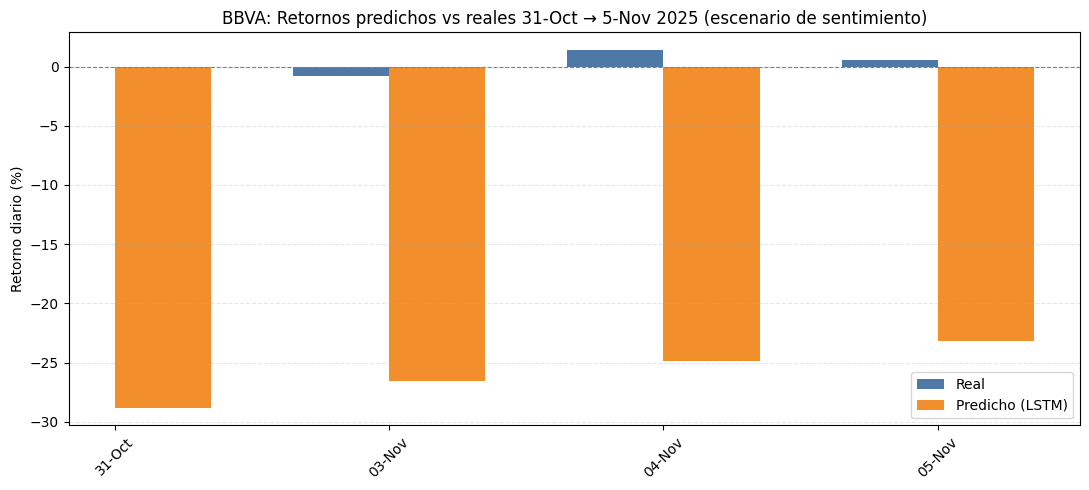

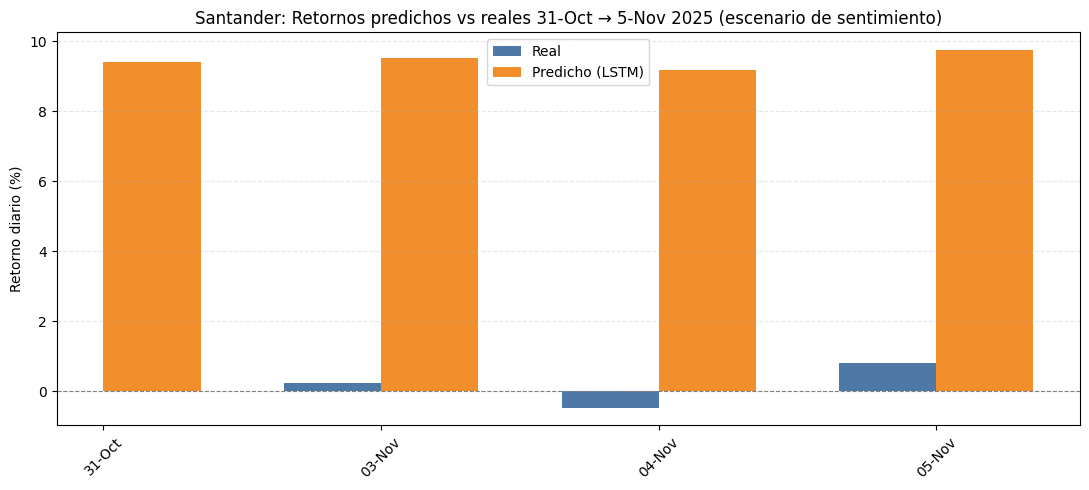

In [52]:
# Diccionarios {fecha: sentimiento} para inyectar
bbva_map = dict(zip(bbva_sent_esc["Date"], bbva_sent_esc["Sentiment"]))
san_map  = dict(zip(san_sent_esc["Date"],  san_sent_esc["Sentiment"]))

# Forecast con escenario
bbva_forecast_scen = forecast_with_sentiment_map("BBVA", bbva_data, bbva_master, bbva_map, days=5, model_kind="LSTM")
san_forecast_scen  = forecast_with_sentiment_map("SAN",  san_data,  san_master,  san_map,  days=5, model_kind="LSTM")

# Función de barras (como la tuya)
import numpy as np

def plot_barras_pred_vs_real(nombre, forecast_df, real_df, titulo_extra="(escenario de sentimiento)"):
    df = (forecast_df.merge(real_df[["Date","Return_real"]], on="Date", how="left")
                    .query("Date <= '2025-11-05'")
                    .sort_values("Date")
                    .assign(Predicho_pct=lambda d: d["Predicted_Return"]*100,
                            Real_pct=lambda d: d["Return_real"]*100))
    x = np.arange(len(df))
    width = 0.35
    plt.figure(figsize=(11,5))
    plt.bar(x - width/2, df["Real_pct"], width, label="Real", color="#4E79A7")
    plt.bar(x + width/2, df["Predicho_pct"], width, label="Predicho (LSTM)", color="#F28E2B")
    plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
    plt.xticks(x, df["Date"].dt.strftime("%d-%b"), rotation=45)
    plt.ylabel("Retorno diario (%)")
    plt.title(f"{nombre}: Retornos predichos vs reales 31-Oct → 5-Nov 2025 {titulo_extra}")
    plt.legend()
    plt.grid(alpha=0.3, linestyle="--", axis="y")
    plt.tight_layout()
    plt.show()
    return df

bbva_cmp_scen = plot_barras_pred_vs_real("BBVA", bbva_forecast_scen, bbva_real)
san_cmp_scen  = plot_barras_pred_vs_real("Santander", san_forecast_scen, san_real)


In [53]:
def resumen_cmp(df):
    out = df.copy()
    out["Acierto_direccion"] = (out["Predicho_pct"] * out["Real_pct"]) > 0
    out["Error_abs_pp"] = (out["Predicho_pct"] - out["Real_pct"]).abs()
    return out[["Date","Predicho_pct","Real_pct","Acierto_direccion","Error_abs_pp"]]

print("=== BBVA — resumen escenario ===")
display(resumen_cmp(bbva_cmp_scen))

print("=== SAN — resumen escenario ===")
display(resumen_cmp(san_cmp_scen))


=== BBVA — resumen escenario ===


,Date,Predicho_pct,Real_pct,Acierto_direccion,Error_abs_pp
0,2025-10-31,-28.801215,NaN,False,NaN
1,2025-11-03,-26.540673,-0.774306,True,25.766367
2,2025-11-04,-24.879062,1.387293,False,26.266355
3,2025-11-05,-23.214798,0.570117,False,23.784914


=== SAN — resumen escenario ===


,Date,Predicho_pct,Real_pct,Acierto_direccion,Error_abs_pp
0,2025-10-31,9.410151,NaN,False,NaN
1,2025-11-03,9.530722,0.237932,True,9.292790
2,2025-11-04,9.174611,-0.463438,False,9.638049
3,2025-11-05,9.749207,0.806270,True,8.942937
